# **Data Mining -- Project 2023 -- SFIKAS THEODORE 1072550**
The purpose of the project is a simple implementation of data mining techiques and methodologies, as a training exercise.    
The data set in use: `data.csv` includes information and statistics about the *COVID-19* pandemic for 104 countries.

### **The purpose:** 
* Utilize **basic** data preprocessing techinques, **examine** the starting data set, find **correlations** between the  
different fields and perform a **basic** statistical analysis on the whole data set.
* **Visualize** the above findings with the help of appropriate graphs.
* **Cluster** the different countries by how well they dealed with the pandemic.
* Separating **Greece** from the dataset, create two daily **predictors** for the *positive test rate* for the next 3 days.  
Train two **regresors**, one based on *RNNs* and one *SVM*. Analysize the results.

### **1. Basic data analysis and visualization:**
In the begging we will try to find some basic patterns, trends and correlations between the records, columns and countries in the dataset.  


In [178]:
# Just a function to display results nicely:

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4></td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

In [179]:
%%time

# Import the basic libraries
%matplotlib inline
from IPython.display import HTML, display
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Read the data into a DataFrame
covid19_df = pd.read_csv('data.csv')

# Print the basic information about the DataFrame
display(covid19_df.info())
display(covid19_df.describe())

# Calculate the median for each column
cols_to_exlude = ['Entity','Continent',"Date"]
column_medians = covid19_df.drop(columns=cols_to_exlude).median()

# Showcase the median for each column
display_table([["Median Values for each column:"]])
display_table([column_medians.index, column_medians.values])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38472 entries, 0 to 38471
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Entity                           38472 non-null  object 
 1   Continent                        38472 non-null  object 
 2   Latitude                         38472 non-null  float64
 3   Longitude                        38472 non-null  float64
 4   Average temperature per year     38472 non-null  int64  
 5   Hospital beds per 1000 people    38472 non-null  float64
 6   Medical doctors per 1000 people  38472 non-null  float64
 7   GDP/Capita                       38472 non-null  float64
 8   Population                       38472 non-null  int64  
 9   Median age                       38472 non-null  int64  
 10  Population aged 65 and over (%)  38472 non-null  int64  
 11  Date                             38472 non-null  object 
 12  Daily tests       

None

,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),Daily tests,Cases,Deaths
count,38472.000000,38472.000000,38472.000000,38472.000000,38472.000000,38472.000000,3.847200e+04,38472.000000,38472.000000,3.057700e+04,3.821800e+04,34862.000000
mean,23.737060,20.210847,17.717145,3.165305,2.086313,19002.331415,4.896983e+07,32.751508,10.663392,3.944059e+04,2.879027e+05,8090.504733
std,26.060413,61.074922,8.134926,2.561767,1.518252,22271.107786,1.427251e+08,8.472305,6.770417,1.501847e+05,1.405243e+06,29548.753221
min,-40.900000,-106.350000,-2.000000,0.200000,0.020000,411.600000,3.412840e+05,16.000000,1.000000,-2.391720e+05,1.000000e+00,1.000000
25%,8.620000,-3.440000,11.000000,1.400000,0.820000,3659.000000,4.793900e+06,27.000000,5.000000,1.505000e+03,2.074000e+03,77.000000
50%,27.510000,21.820000,20.000000,2.500000,1.890000,8821.800000,1.148464e+07,32.000000,8.000000,5.520000e+03,2.143100e+04,527.000000
75%,45.940000,47.480000,25.000000,4.490000,3.210000,25946.200000,4.286296e+07,41.000000,16.000000,2.038200e+04,1.373770e+05,3480.500000
max,64.960000,179.410000,29.000000,13.050000,7.520000,114704.600000,1.339180e+09,48.000000,28.000000,2.945871e+06,2.860567e+07,513091.000000


Median Values for each column:


Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),Daily tests,Cases,Deaths
27.51,21.82,20.0,2.5,1.89,8821.8,11484636.0,32.0,8.0,5520.0,21431.0,527.0


CPU times: user 53.2 ms, sys: 0 ns, total: 53.2 ms
Wall time: 52.9 ms


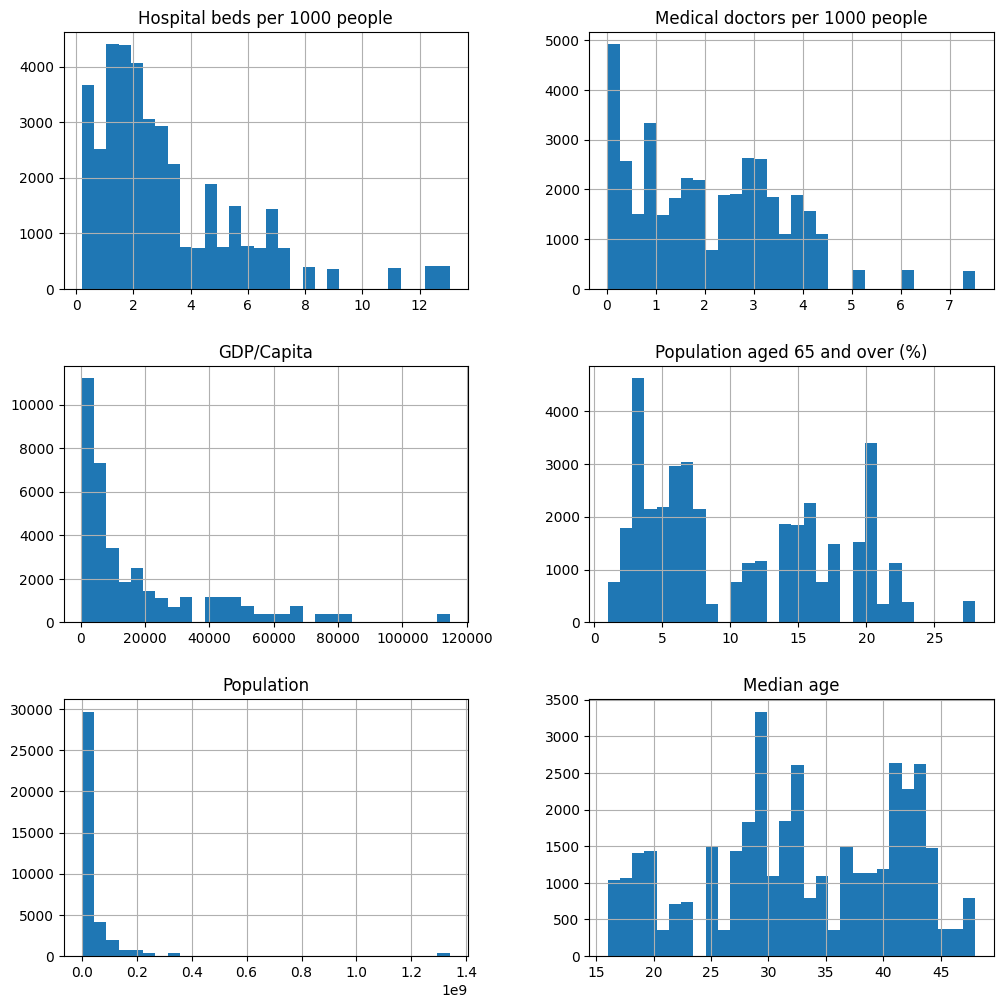

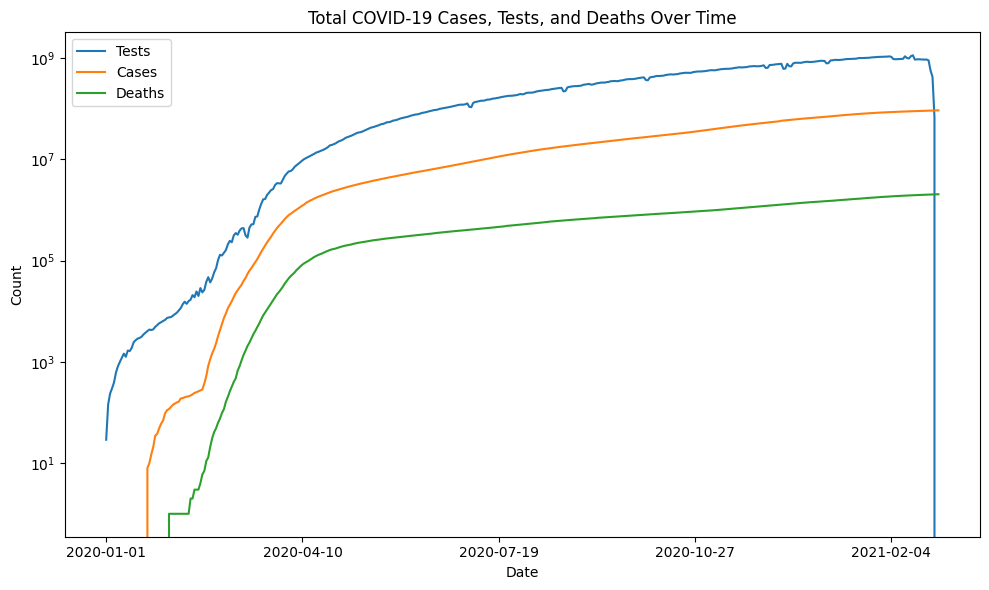

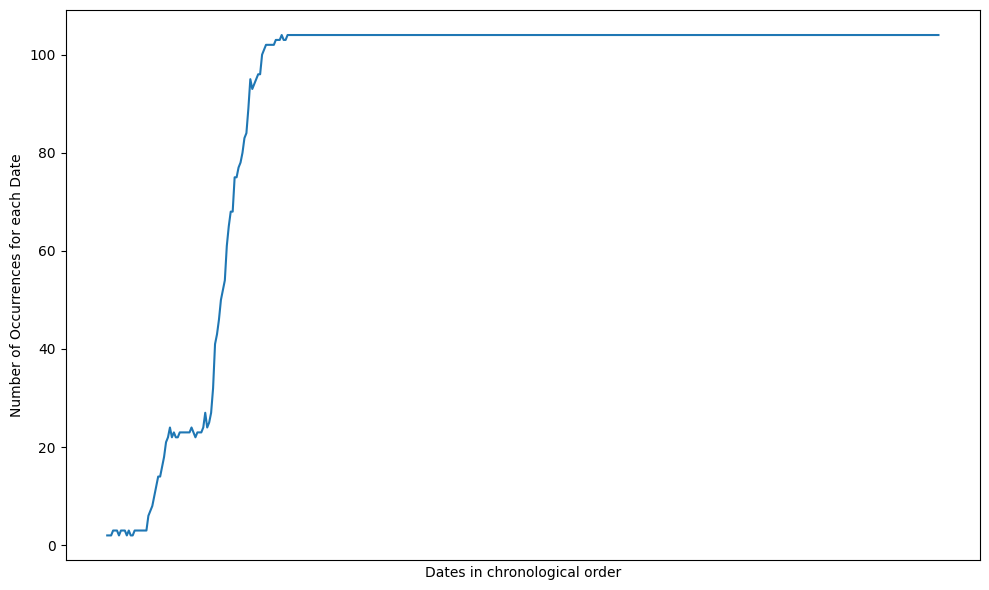

CPU times: user 797 ms, sys: 428 ms, total: 1.23 s
Wall time: 748 ms


In [180]:
%%time
### Plot the distributions of different features

subset_df = covid19_df[["Hospital beds per 1000 people", "Medical doctors per 1000 people",
                        "GDP/Capita", "Population aged 65 and over (%)", "Population", "Median age"]]
subset_df.hist(bins=30, figsize=(12,12))
plt.show()

# A second step to understand the dataset is to check whether there are any 
# missing dates into the data set.
date_counts = covid19_df["Date"].value_counts().sort_index()

### Plot the trend of cases, tests, and deaths over time

# Calculate cumulative sum of tests for each country
covid19_df['Cumulative tests'] = covid19_df.groupby('Entity')['Daily tests'].cumsum()
# Aggregate the sum of cases, cumulative tests, and deaths by date
grouped_df = covid19_df.groupby('Date').agg({'Cases': 'sum', 'Cumulative tests': 'sum', 'Deaths': 'sum'})

plt.figure(figsize=(10, 6))

# Plot cumulative tests
grouped_df['Cumulative tests'].plot(label='Tests')
# Plot cases
grouped_df['Cases'].plot(label='Cases')
# Plot deaths
grouped_df['Deaths'].plot(label='Deaths')

plt.xlabel('Date')
plt.ylabel('Count')
plt.yscale('log')  # Set y-axis scale to logarithmic
plt.title('Total COVID-19 Cases, Tests, and Deaths Over Time')
plt.legend()
plt.tight_layout()
plt.show()

### Plot the number of occurrences for each date

plt.figure(figsize=(10, 6))
date_counts.plot(kind='line')
plt.xlabel('Dates in chronological order')
plt.ylabel('Number of Occurrences for each Date')
plt.xticks([])  # Hide x-axis tick labels for readability

plt.tight_layout()
plt.show()


#### **First Observations from a basic statistical analysis:**
1. From the first set of histograms we can of course see that the data is **not normally distributed**.  
The distributions for the number of **Hospital beds and medical Doctors** show a distinct **similarity**.  
A relative resemblance with the aforementioned distributions can be seen by examining the GPT/Capita   
(Gross Domestic Product per capita) distribution. It is imporant to note that GPT is **not** a perfect  
index of a country's wealth, but just a good **indicator**. The low percentage of the *wealthy* countries  
**match** the low percentage of the countries with a **high** number of hospital **beds and doctors**.  
2. The majority of the countries share a **similar** population, with a few expected exceptions.  
3. A vague **correlation** can be also detected between the percentage of the population that is **over 65**  
with the distribution of median **age**. This is expected, since the older the population, the higher the  
median age, but through the graph alone we **cannot reach** to any precise conclusion.  
4. Examining the trends of the **total tests, cases and deaths** over the months, the number of tests raises  
**exponentially** while the number of cases and deaths although they **increase** as well, they do so in a  
more **linear** fashion *( The scale in the graph is logarithmic to better showcase the changing values )*.  
For the last month, we can detect a sudden **drop** to the number of tests, which could either signify  
missing values or a **change** in the way the data is collected.  
5. Lastly through the last graph we can see that **not** all countries have **recorded** the pandemic's  
behavior for every **day**. At the start of the pandemic not all countries recorded the data daily, but  
as the time passed we seem to have a **more complete** dataset. This is important to note, since we will  
have to **take** this into account when we will try to **predict** the future behavior of the pandemic,   
and categorize the countries based on their **performance**.


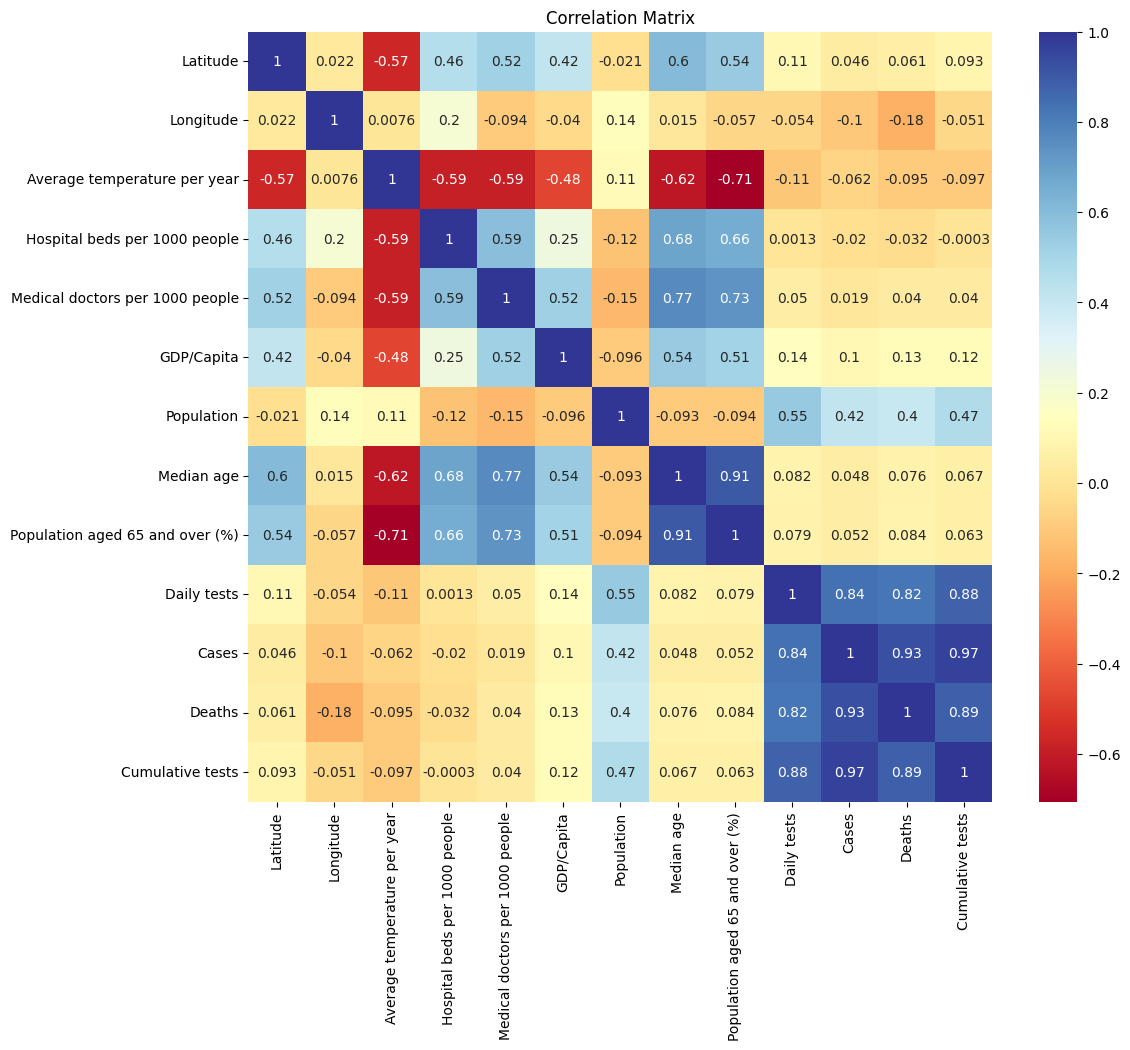

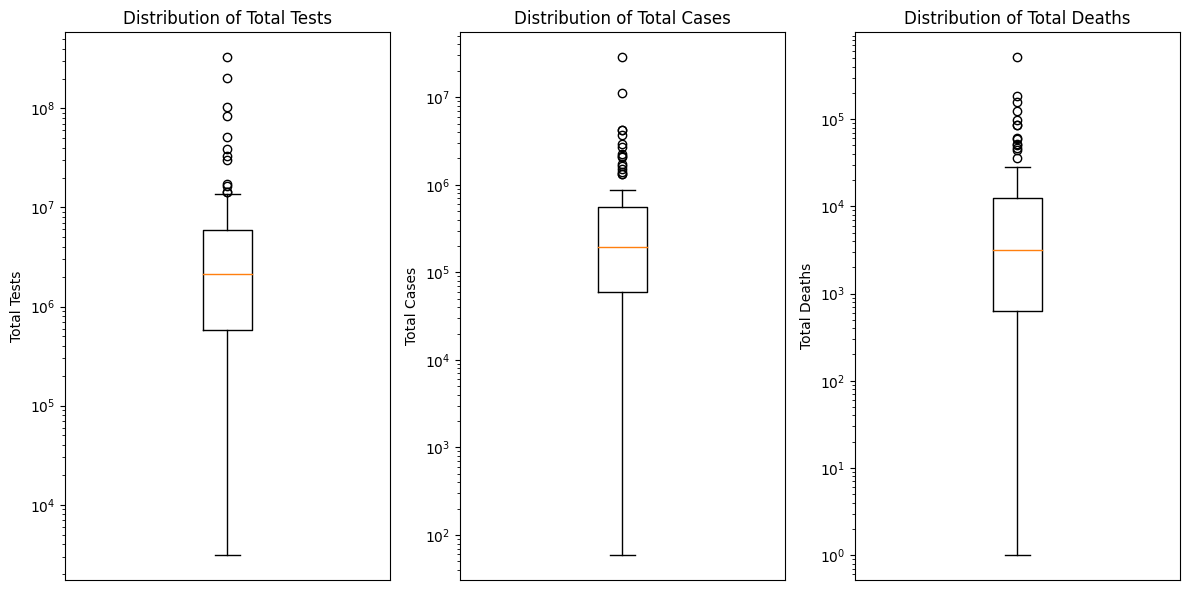

CPU times: user 1.35 s, sys: 423 ms, total: 1.77 s
Wall time: 1.3 s


In [181]:
%%time

# create a basic heatmap from the pandas dataframe.
# The columns Entity, Continent are qualitive and will be exluded
# We will also exlude the Dates Column due to the format.
cols_to_exlude = ['Entity','Continent',"Date"]
covid19_df_subset = covid19_df.drop(columns=cols_to_exlude)
correlation_matrix = covid19_df_subset.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="RdYlBu")
plt.title("Correlation Matrix")
plt.show()

# We will also try to visualize the input data set so we can detect some 
# outlier values. A BoxPlot may prove to be a good graph.
# In order to do a meaningful visualization we will need to compare the 
# different countries with each other. We will use the Daily tests column
# as a proof of concept.

grouped_countries_df = covid19_df.groupby("Entity")
countries_subset_pd = pd.DataFrame(columns=["Entity", "Total Cases", "Total Deaths", "Total Tests"])
for name, country_df in grouped_countries_df:
	total_cases = country_df.iloc[-1]["Cases"]
	total_deaths = country_df.iloc[-1]["Deaths"]
	total_tests = country_df["Daily tests"].sum()


	record = {"Entity": name, "Total Cases": total_cases, \
	"Total Deaths": total_deaths, "Total Tests": total_tests}
	countries_subset_pd.loc[len(countries_subset_pd)+1] = record

# Create a boxplot to showcase the distribution of the data
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

# Total Tests
bp_tests = axes[0].boxplot(countries_subset_pd["Total Tests"])
axes[0].set_ylabel('Total Tests')
axes[0].set_title('Distribution of Total Tests')
axes[0].set_yscale('log')
axes[0].set_xticks([])

# Total Cases
bp_cases = axes[1].boxplot(countries_subset_pd["Total Cases"])
axes[1].set_ylabel('Total Cases')
axes[1].set_title('Distribution of Total Cases')
axes[1].set_yscale('log')
axes[1].set_xticks([])

# Total Deaths
bp_deaths = axes[2].boxplot(countries_subset_pd["Total Deaths"])
axes[2].set_ylabel('Total Deaths')
axes[2].set_title('Distribution of Total Deaths')
axes[2].set_yscale('log')
axes[2].set_xticks([])
    
# Adjust spacing between subplots
plt.tight_layout()
plt.show()

# We can see that the data is skewed to the right. This means that the
# median is lower than the mean. This is due to the fact that there are
# some countries that have a lot of tests, cases and deaths. We will
# try to find the outliers in the data set later on.

outliers = [bp_tests["fliers"][0].get_ydata(), \
			bp_cases["fliers"][0].get_ydata(), \
			bp_deaths["fliers"][0].get_ydata() ]

# Find outliers in Total Tests
tests_fliers = countries_subset_pd[countries_subset_pd["Total Tests"].isin(outliers[0])]
# Find outliers in Total Cases
cases_fliers = countries_subset_pd[countries_subset_pd["Total Cases"].isin(outliers[1])]
# Find outliers in Total Deaths
deaths_fliers = countries_subset_pd[countries_subset_pd["Total Deaths"].isin(outliers[2])]
# Display the outliers
display_table([	["Tests Outliers Countries:"] + tests_fliers["Entity"].tolist(), \
	       		["Cases Outliers Countries:"] + cases_fliers["Entity"].tolist(), \
				["Deaths Outliers Countries:"]+ deaths_fliers["Entity"].tolist() ])



#### **Some basic but interesting conclusions from the correlation matrix:**
1. As it is expected, fundamentally there is correlation between the number of **Daily Tests, Cases and the Deaths**.
2. We can also extract a correlation between the **population size** of each country with the number of **Tests,  
Cases and Deaths** that is also mostly expected.
3. A more unexpected correlation is the percentage of **population above 65** with the number of hospital **beds**  
and **doctors** per 1000 people. A similar correlation can be detected with the **longitude**. The correlation could  
be attributed to the number of more developed countries in the northen hemisphere that constitutes to bigger  
lifespans and better quality of life.

#### **Some basic conclusions from the boxplots:**
1. Because in some countries the outlier values were too big, we used a **logarithmic scale** in order to better visualize the data.
2. For each country we computed the total number of Tests, Cases and Deaths and we plotted the boxplots for each attribute.  
We can extract the **number of outlier** values for each attribute and the distribution of the values. The lower whisker of the boxplots  
seem large but this is due to the logarithmic scale. The upper whisker is more representative of the data. We could also **map the outlier**  
values with the **countries** that they belong to.
3. A country that seems to be an outlier is not necessarily an outlier in all the attributes. For example, **Canada** is an outlier in the  
number of **Tests** and **Cases** but not in the number of **Deaths**. This could be attributed to the fact that the number of deaths is  
not directly proportional to the number of tests and cases. The number of deaths is more related to the **healthcare system** of each country.  
In that note, outliers do not always signify a problematic behavior in the dataset.
4. Sandly we can **not detect** the outlier countries in the boxplots that have small values. In truth we **expected** that the boxplot whould    
also point to the countries with a lot of **missing values** as well. For example **Iran** may have a lot of Cases and Deaths but it has very   
few Tests due to the missing values. Nevertheless, with the above points in mind, we can still extract some useful information from the  
boxplots, and draw some conclusions about the dataset.  





### **2. Data Preprocessing:**

In [182]:
%%time

# Based on a given Decline percentage, we will calculate the percentage of the missing
# values in each column / the total number of rows. If it exceeds the decline_percentage
# the country will be deemed unusable.
decline_percentage = 0.5

grouped_countries_df = covid19_df.groupby("Entity")
dropped_countries = []
for name, country_df in grouped_countries_df:
    num_records = country_df.shape[0]
    flag = False  # flag variable to check if any column exceeds decline_percentage
    for column in ["Daily tests", "Cases", "Deaths"]:
        missing_percentage = country_df[column].isnull().sum() / num_records
        if missing_percentage > decline_percentage:
            flag = True
            break  # break the loop early if any column exceeds decline_percentage
    if flag:
        dropped_countries.append(name)
        covid19_df = covid19_df[covid19_df['Entity'] != name]

# Print the dropped countries        
display_table( [["Dropped countries:"] + dropped_countries] )

# Print the number of null values in each column
null_values = covid19_df[["Daily tests", "Cases", "Deaths"]].isna().sum().values
display_table([["Null Daily tests", null_values[0]], ["Null Cases", null_values[1]], ["Null Deaths", null_values[2]]])


Dropped countries:,Algeria,Armenia,Belarus,Bhutan,Iran,Jordan,Kenya,Madagascar,Mauritania,Mongolia,Nigeria,Oman,Vietnam


Null Daily tests,4558
Null Cases,254
Null Deaths,2574


CPU times: user 54.2 ms, sys: 74 µs, total: 54.3 ms
Wall time: 53.5 ms


We can conclude that the data set is not very large, but it is very rich in information.  
However, **13 countries** have missing data more than the **artibrary** threshold of **50%** and will be  
removed from the dataset, beeing deemed **unusable**. We can not beging to draw any conclusions,  
with that many missing values. The threshold is arbitrary and can be changed, but we followed  
a trial and error approach seeing the results of different percentages.  

We will provide the amount of missing values **before and after** the removal of those 13 countries:  
|              	| Before 	| After 	|
|--------------	|--------	|-------	|
| Daily Deaths 	| 7895   	| 4558  	|
| Cases        	| 254    	| 254   	|
| Deaths       	| 3610   	| 2574  	|
  
The percentage of removed records is around **12.4%** of the total. But in contrast the percentage of  
removed missing Daily Deaths is around **57.7%** of beginning total.

In [183]:
# Before we are ready to draw any conclusive result from the data we need to make sure that the same 
# dates are present for all countries. We will drop any date that is not present for all countries. 

# Group the DataFrame by "Date" and count the number of unique countries for each date
date_counts = covid19_df.groupby("Date")["Entity"].nunique()

# We will store all the dates that are not present for all countries in a list
common_dates = date_counts[date_counts == date_counts.max()].index.tolist()

# will will drop all the rows that do not have a date in the common_dates list
covid19_df = covid19_df[covid19_df["Date"].isin(common_dates)]
covid19_df = covid19_df.reset_index(drop=True)

# Print the number of null values in each column
null_values = covid19_df[["Daily tests", "Cases", "Deaths"]].isna().sum().values
display_table([["Null Daily tests", null_values[0]], ["Null Cases", null_values[1]], ["Null Deaths", null_values[2]]])


Null Daily tests,3000
Null Cases,1
Null Deaths,521


We can observe that a lot of the **missing data** were found in records we dropped due to the **missing dates**.  
However, we before moving to the next steps, we will **fill** the missing values of the **remaining** records.  
*We have a couple of options for filling them:*
0. Fill them with **zeros** or **drop** the rows. Not a good idea
1. Fill them with the **mean** of the column, But this will **skew** the **cumulative** data
2. Fill them with the not null **value** from the **previous record** *(Forward fill)* or the  
**succeeding record** *(backwards fill)*.
3. **Interpolate** the values. This would be a good option as it would **preserve the trend** of the data  
  
Both options 2 and 3 are good, but we will first try to **interpolate** the values since the values **follow a trend**  
and are **mostly continuous** and **numeric**.

In [184]:
# Knowing the trend of the data, we can use interpolation to fill in the missing values.
# We believe that the quadratic interpolation will be the best fit for the data.
covid19_df.interpolate(method='quadratic', inplace=True)

# Interpolation could not fill a very few missing values in the daily tests columns
# We will use forward fill for the rest.
covid19_df["Daily tests"].fillna(method='ffill', inplace=True)

# Print the number of null values in each column
null_values = covid19_df[["Daily tests", "Cases", "Deaths"]].isna().sum().values
display_table([["Null Daily tests", null_values[0]], ["Null Cases", null_values[1]], ["Null Deaths", null_values[2]]])


Null Daily tests,0
Null Cases,0
Null Deaths,0


#### **Results from the preprocessing steps:**

1. We removed the records whose **Date feature** was **not** present for all the countries. This was done  
in order to provide a **consistent** dataset for the clustering algorithm. The number of Cases or Deaths  
are cumulative in the dataset. We did **not** recalculate the values for the removed records, since we  
believe that the **provided** values are more **representative** of the pandemic's behavior. The only  
exception was the **Daily Deaths** feature. For the next steps we will use the number of **Total Tests**  
per country. Having more records on certain countries could **bias** the clustering algorithm.
2. We **filled** the missing values from the dataset. The major problem with the **missing values** could be  
detected in the **starting dates** from each country. Removing the dates that were not present for all the  
countries, we were left with a **more complete** dataset. The missing values after were filled with **interpolation**
3. After the preprocessing we recalculate a correlation matrix to detect slight changes in the values.


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),Daily tests,Cases,Deaths,Cumulative tests
count,30394.00000,30394.000000,30394.000000,30394.000000,30394.000000,30394.000000,3.039400e+04,30394.000000,30394.000000,3.039400e+04,3.039400e+04,30394.000000,3.039100e+04
mean,23.37011,15.901319,17.538462,3.196484,2.133407,20607.368132,4.825868e+07,33.329670,11.252747,4.027942e+04,3.493992e+05,9030.658959,4.859039e+06
std,26.98868,62.424661,8.036188,2.465496,1.538847,22880.365953,1.466411e+08,8.491965,6.791498,1.542810e+05,1.567744e+06,31441.482439,2.109569e+07
min,-40.90000,-106.350000,-2.000000,0.300000,0.020000,411.600000,3.412840e+05,16.000000,1.000000,-2.953229e+05,3.000000e+00,0.630109,-1.404906e+06
25%,7.95000,-8.240000,11.000000,1.380000,0.840000,4135.600000,4.813608e+06,27.000000,5.000000,1.740000e+03,5.090000e+03,106.000000,1.336292e+05
50%,26.34000,19.500000,20.000000,2.540000,1.960000,9946.000000,1.148464e+07,33.000000,10.000000,6.090140e+03,3.301550e+04,613.000000,5.580300e+05
75%,46.15000,43.680000,25.000000,4.500000,3.210000,31846.200000,3.827462e+07,41.000000,18.000000,2.169275e+04,1.806750e+05,4730.750000,2.283310e+06
max,64.96000,179.410000,29.000000,13.050000,7.520000,114704.600000,1.339180e+09,48.000000,28.000000,2.945871e+06,2.860567e+07,513091.000000,3.284051e+08


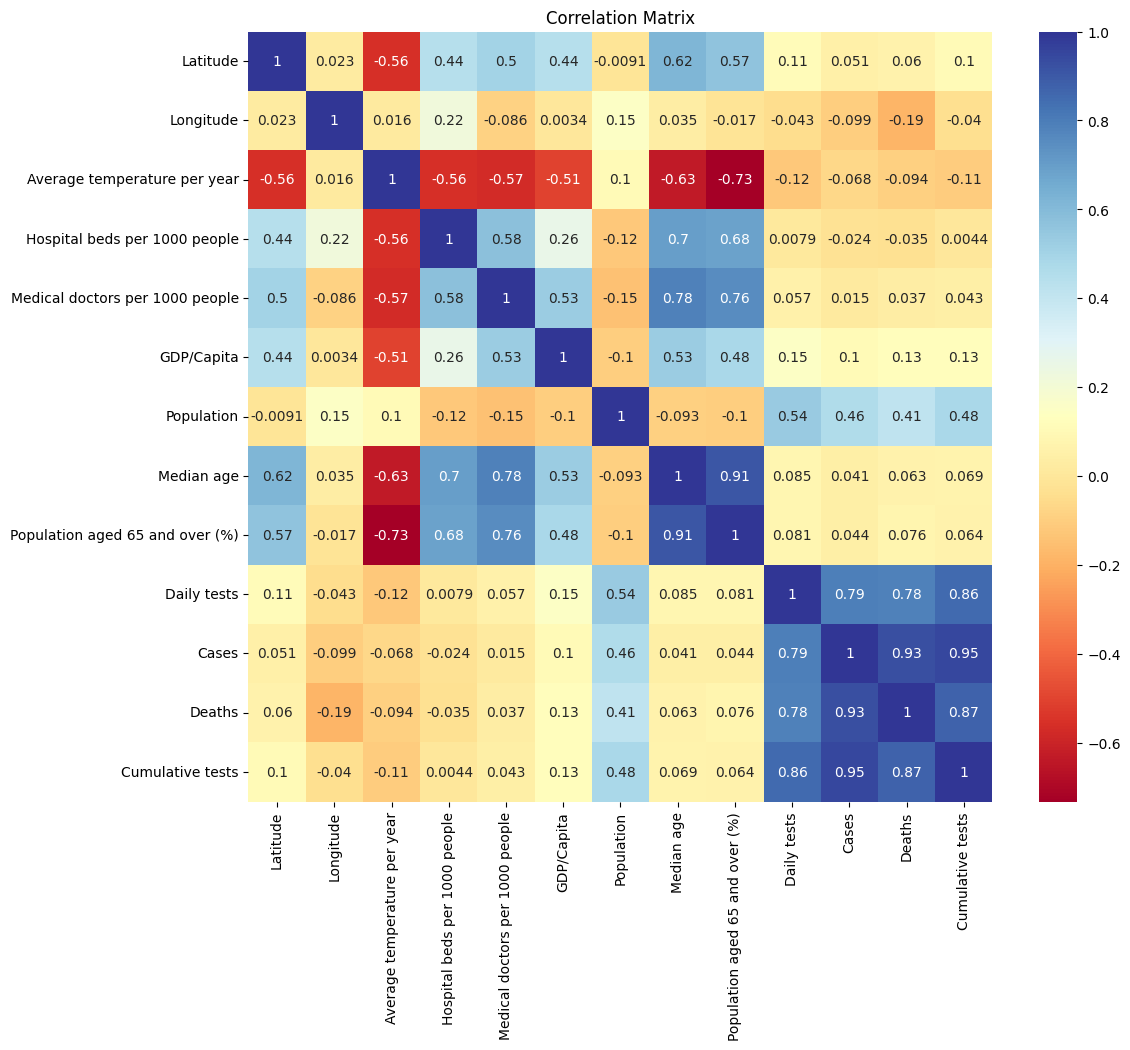

In [185]:
# Statistical Analysis
display(covid19_df.describe())

# Compute the correlation matrix
cols_to_exlude = ['Entity','Continent',"Date"]
covid19_df_subset = covid19_df.drop(columns=cols_to_exlude)
correlation_matrix = covid19_df_subset.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="RdYlBu")
plt.title("Correlation Matrix")
plt.show()

**We can detect that the preprocessing process did not alter the correlation between the different features.**  
**This could be at least singify to a not catastrophic preprocessing process**  


### **3. Data Clustering:**  
  
We wish to cluster the countries based on their **performance** during the pandemic.  
*Under Consideration:*
1. **Feature Extraction**. Which features are more important for the clustering algorithm?
2. **Feature Scaling**. Do we need to scale the features? If yes, which scaling method is   
more appropriate?
3. Clustering Algorithm. **Which algorithm** is more appropriate for the task? What is the  
optimal **number of clusters**?
4. How to combat **overfitting, underfitting, bias, variance**? 
5. Cluster Evaluation. How can we **evaluate** the results of the clustering algorithm?  
6. How can we **visualize** the results of the clustering algorithm?

In [186]:
# Imported libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

import plotly.express as px
import plotly.graph_objects as go



In [187]:
# 1. We will decide to use 4 compositive features for our clustering.
#  - Positivity Rate = Cases / Daily Tests
#  - Fatality Rate = Deaths / Cases
#  - Tests per population = Daily Tests / Population
#  - Maybe -> Deaths per hostpital beds = Deaths / Hospital beds

# Recalcutate the cumulative tests for each country
covid19_df.loc[:, 'Cumulative tests'] = covid19_df.groupby('Entity')['Daily tests'].cumsum()

# In a new Dataframe calculate the 4 aformentioned features
covid19_df_metrics = pd.DataFrame(columns=["Country","Positivity Rate", "Fatality Rate", "Tests/population"])
for name, country_df in covid19_df.groupby("Entity"):
	total_cases = country_df["Cases"].iat[-1]
	total_deaths = country_df["Deaths"].iat[-1]
	total_tests = country_df["Cumulative tests"].iat[-1]
	population = country_df["Population"].iat[0]
			
	positivity_rate = total_cases / total_tests
	fatality_rate = total_deaths / total_cases
	tests_per_population = total_tests / population

	covid19_df_metrics.loc[len(covid19_df_metrics)+1] = [name,positivity_rate, fatality_rate, tests_per_population]

# Display the first 5 rows of the new dataframe
display_table([["Starting Dataframe:"]])
display(covid19_df_metrics.head())

# Prior to model-fitting we need to normalize the data to avoid creating bias.

# 3 different scalers were considered: MinMaxScaler, StandardScaler, RobustScaler
# We decided to use RobustScaler because it is less prone to outliers than the other two and 
# it also preserves the variance better than the StandardScaler.
# There is also the possibility of combining the RobustScaler with the MinMaxScaler to further
# improve the results.
columns_to_scale = ["Positivity Rate", "Fatality Rate", "Tests/population"]

robust_scaler = RobustScaler()
data_for_clustering = robust_scaler.fit_transform(covid19_df_metrics[columns_to_scale])
covid19_df_metrics[columns_to_scale] = data_for_clustering
display_table([["Dataframe after Robust Scaler:"]])
display(covid19_df_metrics.head())

# standard_scaler = StandardScaler()
# data_for_clustering = standard_scaler.fit_transform(covid19_df_metrics[columns_to_scale])
# covid19_df_metrics[columns_to_scale] = data_for_clustering
# display_table([["Dataframe after Standard Scaler:"]])
# display(covid19_df_metrics.head())

minMax_scaler = MinMaxScaler()
data_for_clustering = minMax_scaler.fit_transform(covid19_df_metrics[columns_to_scale])
covid19_df_metrics[columns_to_scale] = data_for_clustering
display_table([["Dataframe after MinMax Scaler:"]])
display(covid19_df_metrics.head())
	

Starting Dataframe:


,Country,Positivity Rate,Fatality Rate,Tests/population
1,Albania,0.241262,0.016759,0.154585
2,Argentina,0.357304,0.024659,0.133224
3,Australia,0.002030,0.031369,0.580268
4,Austria,0.030912,0.018634,1.687194
5,Bahrain,0.035631,0.003668,2.301382


Dataframe after Robust Scaler:


,Country,Positivity Rate,Fatality Rate,Tests/population
1,Albania,1.608599,-0.088439,-0.142647
2,Argentina,2.699798,0.464894,-0.175793
3,Australia,-0.640997,0.934875,0.517867
4,Austria,-0.369409,0.042869,2.235437
5,Bahrain,-0.325030,-1.005335,3.188448


Dataframe after MinMax Scaler:


,Country,Positivity Rate,Fatality Rate,Tests/population
1,Albania,0.723799,0.173687,0.455967
2,Argentina,0.760505,0.264061,0.452477
3,Australia,0.648127,0.340822,0.525522
4,Austria,0.657262,0.195133,0.706390
5,Bahrain,0.658755,0.023933,0.806746


1. In order to **select** the most **important features**, to **cluster** the countries by their performance in combating  
the pandemic, we will follow the indicators of: *Positivity Rate*, *Case Fatality Rate* and the *Tests per Country Population.*  
    
2. In order to avoid a single feature to dominate the clustering algorithm, we will **scale** the features.  
We need to scale the input variables to a **common range** prior to fitting the model. Our input does not  
follow a **normal distribution** and **outliers** are present. We will use the **RobustScaler** method  
to scale the features. The RobustScaler uses the **interquartile range** instead of the **mean** and the  
**standard deviation**. This makes the process more **robust** to **outliers**, but not immune. The **outlier**  
are **still present** with the same **relative relationshoip to the rest of the data.** This is important to  
note because we do not want to **remove** the outliers from the dataset but if possible, cluster them.  
Although the robust scaler might be a good first step for our dataset, it does not constrain the data to a  
specific range. We could use the **MinMaxScaler** to achieve that, **speculating** that the previous scaling will  
**prevent the outliers from dominating the clustering algorithm**.
    
3. We will use the **DBSCAN** algorithm to cluster the countries. DBSCAN unlike k-means is **density-based**,  
and does **not require** any oversampling because it does not assume any particular shape or size of clusters.  
It can discover clusters of arbitrary shapes and adapt to the density of the data. Having **scaled** accordingly  
the dataset, we ensure that the **distance metric** used by DBSCAN is **meaningful and constistent** across all  
the features. We avoided the dominance of a single feature due to the magnitude of its values with the MinMaxScaler.  
However, hyperparameter tuning is required to find the optimal values for the **epsilon** and **min_samples**.  
It's important to note that the choice of **hyperparameters** in DBSCAN is **subjective and context-dependent**. It may  
require some **trial and error** to find the optimal values.

In [188]:
# A good way to find the optimal value for epsilon is to plot the distance of each point to its kth
# nearest neighbor. This is also refereed to as a density reachability plot

# 1. For each data entry we compute the distance from the kth nearest neighbor.
# 2. Sort the distances in ascending order, and plot the distances.
# 3. The optimal value for epsilon is the distance value corresponding to the knee of the curve.
# The distance value corresponding to the knee of the curve is the optimal value for epsilon.

# We will use the NearestNeighbors class to compute the distances
neighbors = NearestNeighbors(n_neighbors=4) # k = 4 number of neighbors
neighbors.fit(data_for_clustering)
distances, indices = neighbors.kneighbors(data_for_clustering)

kDistances = distances[:,-1] # The distance to the kth nearest neighbor
sorted_KDistances = np.sort(kDistances) # Sort the distances in ascending order

# Create the figure
fig = go.Figure()

# Add the reachability distances as a line graph
fig.add_trace(go.Scatter(
    x=list(range(len(sorted_KDistances))),
    y=sorted_KDistances,
    mode='lines',
    name=''
))

fig.update_layout(
    width=800, height=600,
    title='Density Reachability Plot',
    xaxis_title='Data Points',
    yaxis_title='Kth Nearest Distance',
)

# Configure hover behavior to display the coordinates
fig.update_layout(hovermode='closest')
fig.update_traces(hovertemplate='Coordinate: (%{x}, %{y})')

# Show the figure
fig.show()

## ------------ IMPORTANT -------------
# In case plotly does not work, try this: 
# 1. pip install --upgrade jupyter notebook nbformat
# 2. Restart Jupiter Notebook 
# 3. :) Worked for me! 


In [189]:
# Create and fit the DBSCAN model
epsilon = 0.06  # Distance threshold for defining neighborhoods

min_samples = 3  # Minimum number of samples in a neighborhood to form a core point
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(data_for_clustering)
covid19_df_metrics['Cluster'] = clusters

# Get the unique cluster labels
unique_clusters = set(clusters)

table = []
for cluster in unique_clusters:
    cluster_countries = covid19_df_metrics[covid19_df_metrics['Cluster'] == cluster]['Country']
    table.append(["Cluster id :" + str(cluster) + " Number of Countries" + ":" + str(len(cluster_countries)), ', '.join(cluster_countries)])

display_table(table)

# Evaluate the model
# The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters.
# The silhouette scores range from -1 to 1, where a higher value indicates that the object is better matched
# to its own cluster, and worse matched to neighboring clusters.

# Since we used DBSCAN we will need to exlude the noise points from the evaluation
valid_cluster = clusters[clusters != -1]
valid_data = covid19_df_metrics[covid19_df_metrics['Cluster'] != -1][['Positivity Rate', 'Fatality Rate', 'Tests/population']].values
silhouette_score = silhouette_score(valid_data, valid_cluster)
print("Silhouette Score: ", silhouette_score)



Cluster id :0 Number of Countries:60,"Albania, Argentina, Bangladesh, Canada, Chile, Colombia, Costa Rica, Croatia, Cuba, Dominican Republic, Estonia, Ethiopia, Finland, France, Ghana, Iceland, India, Indonesia, Iraq, Ireland, Jamaica, Japan, Kazakhstan, Latvia, Libya, Lithuania, Malaysia, Morocco, Mozambique, Myanmar, Namibia, Nepal, New Zealand, Norway, Pakistan, Panama, Paraguay, Philippines, Poland, Portugal, Romania, Russia, Rwanda, Saudi Arabia, Senegal, Serbia, Slovenia, South Korea, Sri Lanka, Sweden, Switzerland, Thailand, Togo, Trinidad and Tobago, Turkey, Uganda, Ukraine, United States, Uruguay, Zambia"
Cluster id :1 Number of Countries:10,"Australia, Belgium, Bulgaria, Fiji, Greece, Guatemala, Hungary, Italy, South Africa, Zimbabwe"
Cluster id :2 Number of Countries:3,"Cyprus, Israel, Kuwait"
Cluster id :-1 Number of Countries:18,"Austria, Bahrain, Bolivia, Bosnia and Herzegovina, Cape Verde, Denmark, Ecuador, El Salvador, Luxembourg, Malawi, Malta, Mexico, Peru, Qatar, Slovakia, Tunisia, United Arab Emirates, United Kingdom"


Silhouette Score:  0.43144836751533566


In [190]:
# Making this work with jupyter notebook might be a bit tricky.
# I tried : pip install --upgrade jupyter notebook nbformat
# And restarted the notebook, after that it worked.
# The error something likenbformat>4.9 although nbformat was installed.

# Create a trace for each cluster
traces = []
for cluster in unique_clusters:
    # Filter the data points belonging to the current cluster
    cluster_data = covid19_df_metrics[clusters == cluster][['Country','Positivity Rate', 'Fatality Rate', 'Tests/population']].values

    # Create a trace for the current cluster
    trace = go.Scatter3d(
        text = cluster_data[:, 0],
        x=cluster_data[:, 1],
        y=cluster_data[:, 2],
        z=cluster_data[:, 3],
        mode='markers',
        marker=dict(
            size=5,
            color=cluster,  # Assign a unique color to each cluster
            colorscale='Viridis',
            opacity=0.8
        ),
        name=f'Cluster {cluster}'
    )
    traces.append(trace)

# Create the layout and figure
layout = go.Layout(
    scene=dict(
        xaxis_title='Positivity Rate',
        yaxis_title='Fatality Rate',
        zaxis_title='Tests/Population'
    ),
    showlegend=True
)

fig = go.Figure(data=traces, layout=layout)

# Update the size of the figure
fig.update_layout(width=1000, height=1000)

# Customize the hover label format
fig.update_traces(hovertemplate='<b>%{text}</b><br>'
                                'Positivity Rate: %{x:.2f}<br>'
                                'Fatality Rate: %{y:.2f}<br>'
                                'Tests/Population: %{z:.2f}')
# Show the figure
fig.show()

#### **Conclusions from the clustering process:**
1. The use of the **Robust scaler**, did **not prove to be a meaningful choice**. The results with just the **MinMax scaler**  
were the same. The **outliers** affected the clustering algorithm, due to the choice of **DBSCAN** thοse **outliers**  
were detected as **noise** ( countries like: *Mexico, Tunisia and Luxemburg* ) through the process of minmax scaling, the   
**majority** of the other countries are mapped **closer together to the new vector space**. 
2. After the **preprocessing** and **clustering** process, we can conclude that the **DBSCAN** algorithm was able to  
**cluster** the countries in **3 clusters**. The **majority** of the countries however, were **clustered together**.  
This could be attributed to the **small** number of **features** used for the clustering process. The **more features**  
we use, the **more** the **clusters** will **diverge**. However finding features and metrics that **represent** the performance  
of each country to the **pandemic**, could not be easily obtained from the **provided dataset**. The feature of  
**deaths per medical beds or staff** is not surely a **good metric** to represent the **performance** of a country, so  
it was **not used**.
3. More **clustering algorithms like K-mean** were tested, but in our eyes the results of the **DBSCAN** were the most  
**meaningful**. K-means clustered countries that after **visual inspection** were **not similar** in their **performance**,  
while DBSCAN was able to categorize them as **outliers**. In truth we do not know if the dataset is **suitable** for  
the DBSCAN algorithm, but the results were **satisfactory**. There is **room for improvement** in the **clustering**  
process. Maybe with **different preprocessing** we could **achieve** better **results**. Probably countries like:  
*Slovakia, Denmark, Bahrain, United Arab Emirates and Luxembourg* could be **clustered together**, the rest were  
**clustered** correctly enough.
4. Altering the **epsilon** hyperparameter of the DBSCAN algorithm, as expected leads to different **results**. By Lowering  
the **epsilon** value, we could **distinct** countries into more **clusters**. This also improves the **silhouette**  
score of the algorithm. However, the cost is the increase of the **number of outliers**. Following the Density Reachability  
plot proved to indeed provide the most **meaningful** results.
  
#### **Extracting similarities from the clusters:**
1. Most of the countries showed a **similar** behavior in the **positivity rate** and **case fatality rate**. Countries  
clustered on **0** do not show any **significant** resemblance to each other, we can detect countries with *varying GPT*  
and from *every continent*. We could match this cluster with a somewhat **average** performance in the pandemic.  
2. Countries clustered on **1** show a **similar** behavior in the **positivity rate** and **Test/Population** with the  
cluster **0**. However they show a **higher** **case fatality rate**. We could match this cluster with a **poorer** performance  
in the pandemic. Most of them are considered **developed** countries, singnifying that the **healthcare system** and political  
**choices** play a major role in the **performance** of a country. Far worse results can also be detected with the **outlier**  
countries of *Bolivia, Mexico, Tunisia, Ecuador and Cape Verde*. However, all of those countries can be categorized as   
**developing** countries, with **poorer** healthcare systems and **less** resources to combat the pandemic.  
3. Countries clustered on **2** alongside with the outliers of *Slovakia, Denmark, Bahrain, United Arab Emirates and Luxembourg*    
match this cluster with a **better** performance in the pandemic. They show a **lower** **case fatality rate**, with the same  
**positivity rate** as countries from clusters **0** and **1**. The **Test/Population** is also much **higher** than the other  
counties. We can firmly say that the measures taken by the **governments** of those countries, **helped** them **combat** the  
pandemic more **efficiently**.





### 4. **Predict the positivity Rate in Greece**
Train two **regression models:** *SVM and RNN* to predict the positivity rate in Greece.


In [191]:
# Import the basic libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from datetime import datetime

from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import LSTM, Dense
import regex as re

In [192]:
# First filter the data for Greece
# Read the data again with the Date column as a datetime object
covid19_df = pd.read_csv('data.csv', parse_dates=['Date'])
greece_df = covid19_df[covid19_df['Entity'] == 'Greece'].reset_index(drop=True)
greece_population = greece_df['Population'].iloc[0]

# Drop unnecessary columns
dropped_features = ['Entity', 'Continent', 'Latitude', 'Longitude', 'Average temperature per year', \
                    'Hospital beds per 1000 people','Medical doctors per 1000 people', 'GDP/Capita',\
                    'Population','Median age','Population aged 65 and over (%)','Deaths']
greece_df = greece_df.drop(dropped_features, axis=1)

# Apply the basic preprocessing steps
# We can detect that the first 17 records miss the Daily Tests column
greece_df = greece_df[greece_df["Daily tests"].first_valid_index():].reset_index(drop=True)

# After that only select records show missing values in the Daily Tests column
# We could interpolate those values or we could simply drop them.
greece_df = greece_df.dropna().reset_index(drop=True)
# We are left with 302 records from the 369 and no missing values

# Το be able to use the Date column, so we can implement the temoral relational order of the data,
# we will need to convert it to a numerical value.

# We can just use a particular reference date and calculate the difference in days from that date.
# Or we can transform the date to a Timestamp.
reference_date = greece_df.loc[0, 'Date']
greece_df['Days'] = (greece_df['Date'] - reference_date).dt.days

greece_df['Timestamp'] = greece_df['Date'].values.astype(np.int64) // 10 ** 9

# Create a new column for the positivity rate as the ratio of the Daily Cases to the Daily Tests
greece_df['Positivity Rate'] = greece_df['Cases'].diff() / greece_df['Daily tests']
greece_df.loc[0,'Positivity Rate'] = greece_df['Cases'][0] / greece_df['Daily tests'][0]

# Fill the created NA values due to the diff=0 with 0
greece_df = greece_df.fillna(0)

display(greece_df.head())
greece_df.to_csv('greece_df.csv', index=False)

,Date,Daily tests,Cases,Days,Timestamp,Positivity Rate
0,2020-03-13,520.0,190.0,0,1584057600,0.365385
1,2020-03-14,700.0,228.0,1,1584144000,0.054286
2,2020-03-15,600.0,331.0,2,1584230400,0.171667
3,2020-03-16,320.0,331.0,3,1584316800,0.000000
4,2020-03-21,658.0,530.0,8,1584748800,0.302432


After the **preprocessing** of the dataset once again we are left with 302 records from Greece.  
We removed the first records that showed **missing values** in the *Daily Test* features, and  
for the random records that were incomplete, we could either **remove** them or **interpolate** them.  
We chose to drop them because it is imporant to **preserve** the **accurate count of the features**.  
  
We will try to predict the **positivity rate** for a **given day**, we can detect that the timespan  
of the remaining records is between *2020-03-13* and *2021-02-25*. In order to **predict** the   
**positivity rate**, we will **train** the **models** with the **previous records** until **3** days  
before the **wanted date**.  
If we wanted to predict missing values inside the dataset we could train a regression model with  
also the other **correlated features** like the **Test/Population** and the **Fatality Rate**.  
Although, in order to predict the **positivity rate** for a **future date**, we will **only** use   
the **positivity rate** in **relationship with the date**, in order to follow the **trend** of the    
**pandemic**. We should also **normalize** the numerical data to utilize the **relative** change of   
the **positivity rate** through the **days**.   
In order to pass dates to the **models**, we will transform them to **epoch timestamps**. Another   
way would be to calculate the distance of the **date** from the **first date** of the dataset.  

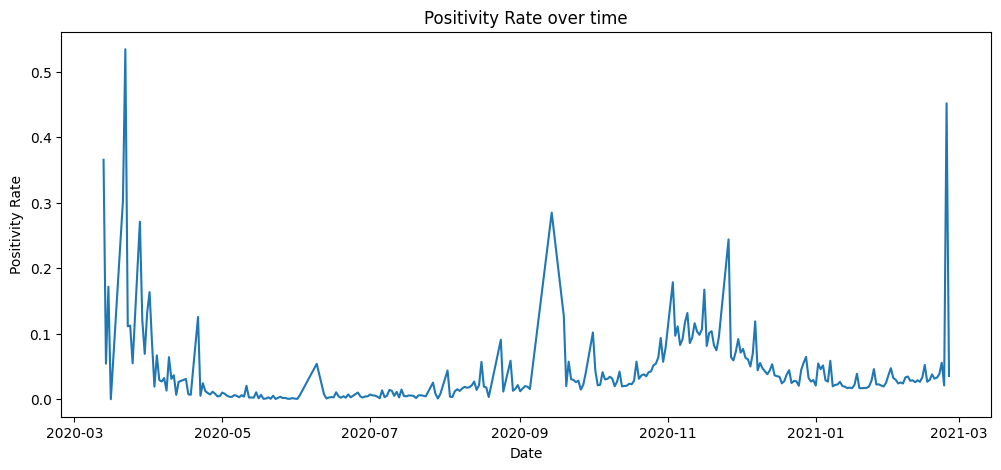

In [193]:
# Before moving forward with the predictors lets better understand the data
# We will plot the positivity rate over time to check for any trends and seasonality

# Create a matplotlib line plot
plt.figure(figsize=(12, 5))
plt.plot(greece_df['Date'], greece_df['Positivity Rate'])
plt.title('Positivity Rate over time')
plt.xlabel('Date')
plt.ylabel('Positivity Rate')
plt.show()


Firstly we can detect large spikes in the **positivity rate** in the **beginning** and the **ending** of our dataset.  
We could **remove** some **outliers** from the dataset, effectively smoothening the trend in order to better train our  
models. It would be best to remove the dates before **1/05/2020** adn the last date due to the huge anomalies in the  
positivity rate.  
We can also *in hindsight* detect a seasonality in the **spikes** of the **positivity rate** after **1/1/2021**. It  
would be a challenge to actually capture this in our **predictions**.

In [194]:
# Drop some outlier records
greece_df = greece_df[greece_df['Date'] >= '2020-05-01'].reset_index(drop=True)
greece_df.head()

,Date,Daily tests,Cases,Days,Timestamp,Positivity Rate
0,2020-05-01,2081.0,2612.0,49,1588291200,0.010091
1,2020-05-02,956.0,2620.0,50,1588377600,0.008368
2,2020-05-03,1125.0,2626.0,51,1588464000,0.005333
3,2020-05-04,1619.0,2632.0,52,1588550400,0.003706
4,2020-05-05,2799.0,2642.0,53,1588636800,0.003573


#### **SVM Regression:**
In order to predict the **positivity rate** we will **train** a **SVM regression model** with the **previous records**  
until **3** days before the **wanted date**. We will **normalize** the positivity rate but not the **dates**.  
We must also detect the **best hyperparameters** for the **model**. We will use **GridSearchCV** to find the best  
**C** and **gamma** hyperparameters.
Lets delve a bit into the **hyperparameters** of the **SVM regression model**.
1. **C** is the **regularization parameter**. It is the **inverse** of the **lambda** parameter. It **controls** the  
**tradeoff** between **minimizing training errors** and **maximizing the margin** between the decision boundary  
and the training examples. A **large** value of **C** means that the the **model** will be infuenced by individual  
**data points**, potentially leading to **overfitting** if the data is noisy or contain outliers. On the other hand  
a smaller C will make a more **tolerant** model, accepting larger number of training errors and **priortizing** a  
better boundary margin.  
2. **Gamma** parameter used with the **appropriate kernel** defines the reach of each training example in the feature  
space. It controls the **shape of the decision boundary** and the flexibility of the model. Specifically, it determines  
the **influence** of each training example on the **decision boundary**.  A small value leads to a smoother decision  
boundary and a more **generalized model** that may be **less prone to overfitting**. Conversely, a large gamma value  
leads to a more **complex** and intricate decision boundary. In this case, data points that are far away from each  
other may have minimal influence on the decision boundary, as the model focuses on nearby examples.  
For a time series where the **temporal trend** is an important factor in making **predictions**, it can be beneficial to  
choose a larger gamma value while avoiding overfitting.
3. The **Kernel type** specifies the type of function used to **transform the input data into higher-dimensional space**.  
Common options include linear, polynomial, and radial basis function (RBF) kernels. The choice of kernel can  
significantly impact the model's performance and is often determined through trial and error.


Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
MSE:  0.00013572239403718262


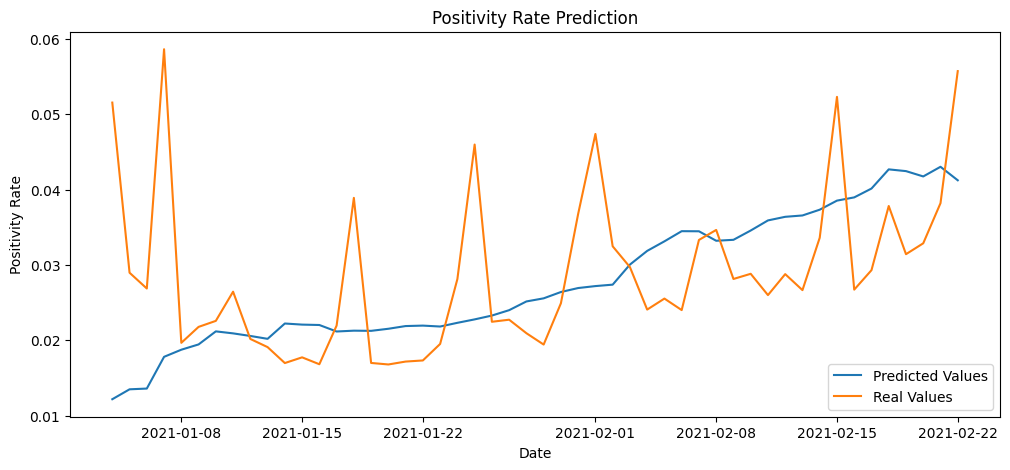

In [195]:
# Use GridSearchCV to find the best parameters for the SVR model

# Extract features and target variables
separation_date = datetime(2021,1,1)
train_dates = greece_df[greece_df['Date'] < separation_date]['Timestamp'].values.reshape(-1, 1)
train_pos_rate = greece_df[greece_df['Date'] < separation_date]['Positivity Rate'].values.reshape(-1, 1)

# Normalize the train_pos_rate
scaler = StandardScaler()
train_pos_rate_scaled = scaler.fit_transform(train_pos_rate)

# Define parameter grid for grid search
param_grid = {
    'kernel': ['rbf'], # Tried 'linear' and 'poly' but 'rbf' gave the best results
    'C': [0.0001, 0.001, 0.01, 1, 10, 20, 100],			
    'gamma': [0.0001, 0.001, 0.1, 1, 10, 100, 'scale', 'auto']
}

# Perform grid search to find the best parameters
grid_search = GridSearchCV(SVR(), param_grid, cv=3)
grid_search.fit(train_dates, train_pos_rate_scaled.ravel())

# Get the best parameters from grid search
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Change the best parameters to the SVR model
best_params['C'] = 8

# Create a list to store the predicted values
predicted_pos_rate_values = []

# Predict the remaining values ( But the last three )
remaining_dates = greece_df[greece_df['Date'] >= separation_date]['Timestamp'][:-3]
remaining_dates = remaining_dates.reset_index(drop=True)
for today in remaining_dates:
	train_dates = np.append(train_dates, today).reshape(-1, 1)

	# Gather the positivity rate found today
	train_pos_rate = np.append(train_pos_rate,greece_df[greece_df['Timestamp'] == today]['Positivity Rate'].iloc[0])
	train_pos_rate = train_pos_rate.reshape(-1, 1)
		
	# Scale the new data
	scaler = StandardScaler()
	train_pos_rate_scaled = scaler.fit_transform(train_pos_rate)

	# Create a new SVR model for each iteration and fit it with the training data
	svr = SVR(**best_params)
	svr.fit(train_dates, train_pos_rate_scaled.ravel())

    # calculate the timestamp for the prediction date (+3 days)
	predict_ts = today + 3*24*60*60

	# Predict the positivity rate for the prediction date
	predicted_value_scaled = svr.predict([[predict_ts]])
	predicted_value = scaler.inverse_transform(predicted_value_scaled.reshape(-1, 1))

	# # Store the predicted value
	predicted_pos_rate_values.append(predicted_value[0][0])

# Calculate the MSE
predicted_pos_rate_values = predicted_pos_rate_values[:-3]
dates = greece_df[greece_df['Date'] >= separation_date]['Date'][3:-3].to_list()
real_pos_rate_values = greece_df[greece_df['Date'] >= separation_date]['Positivity Rate'][3:-3].to_list()
mse = mean_squared_error(real_pos_rate_values, predicted_pos_rate_values)
print('MSE: ', mse)
# print('Real values: ', real_pos_rate_values)
# print('Pred values: ', predicted_pos_rate_values)

# # Plot the predicted values against the real values
plt.figure(figsize=(12, 5))
plt.plot(dates, predicted_pos_rate_values, label='Predicted Values')
plt.plot(dates, real_pos_rate_values, label='Real Values')
plt.title('Positivity Rate Prediction')
plt.xlabel('Date')
plt.ylabel('Positivity Rate')
plt.legend()
plt.show()


The **SVR** seem to be able to follow the general rising trend of the **positivity rate**. However, it is not able to  
follow the **spikes** detected in the real values. This is due to the small time span of each spike. The **model** is  
probably not able to **capture** fast **changes** in the **positivity rate** due to the small amount of **data**.   
Maybe **oversampling** the dataset could help train a better model.  
It is also important to note that the best hyperparameters for the model are **not** the ones that are produced by the  
**GridSearchCV**. The **best** found **C** by trial and error is **8 instead of 1**. Due to the high variance of the  
**positivity rate** the **model** needs to be more **tolerant** to **training errors**. So the best **C** is **1** for  
predicting the **positivity rate** for the whole timespan, but **8** produces better results for the **last 2 months**.  
There are many ways to evaluate the performance of a regression model. We will use the **mean squared error** as  
the most typical metric.

#### **RNN Regression:**
The process of **preprocessing** the data for the **RNN** is the same as the **SVM**. **Standardizing** the  
**positivity rate** is a prerequisite of training the model, the same logic that was explained for the **SVM**  
applies here as well. Building a RNN is a more **complex** process in contrast to the SVR, the hyperparameter  
tuning is much more **difficult**. Typically, dealing with **time series** data, we will use **LSTM** layers that  
are proven to be more **efficient** in **capturing** the **temporal** trends in a dataset.  
Modeling the architcture of the NN might be a **trial and error** process on some occasions. We will need to  
choose the **number of LSTM layers** and the **number of neurons** for each layer, define the need for **dropout**  
layers and the **activation functions**. Generally it is important to configure the input shape of the **model**    
based on the dimensionality of our data, but since we only have **one feature** we might simplify the process.  
Lastly, before compiling the model, we need to choose the **optimizer** and the **loss function**. Popular  
options for **optimizers** include **Adam** and **RMSprop**. The **Adam** optimizer is a popular choice because  
it is **computationally efficient** and **good prerfomance** in a variety of situations. The **loss function** is  
used to **measure** the **difference** between the **predicted** and **actual** values. For **regression** problems,  
the **mean squared error** is a common choice. As the **evaluation set** we will use the dates after *1/1/2021*.  
There is no reason to subdivide the dates before *1/1/2021* again. Other popular options for the **evaluation**  
process include the rolling and expanding window methods.
  
Another approach for the problem would be to shift the **positivity rate** by **3 days** and use it as the **target**.  
This way we will have the ability to train the **model** with **more features** that may have underlying **correlation**.  
This may lead to a better **performance** of the **model** provided that we design the **architecture** of the **NN**  
**correctly enough** to capture the relationship between the **features** and the **target**. We must also make sure  
to avoid the possibility of **overfitting** the **model** and include some **dropout layers**.


2023-06-17 21:36:10.762871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-17 21:36:10.763581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-17 21:36:10.764110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

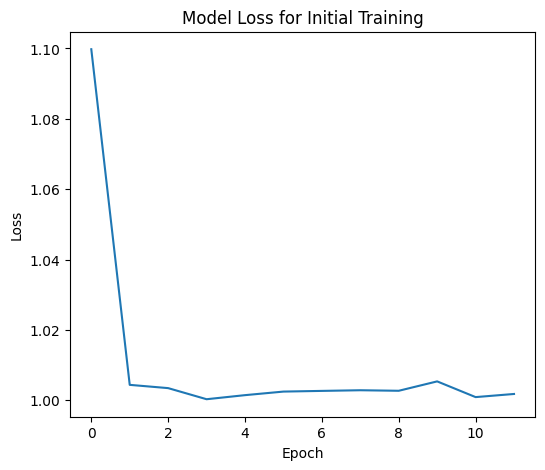

2023-06-17 21:36:12.111387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-17 21:36:12.112182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-17 21:36:12.112759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

MSE:  0.00012055345152637777


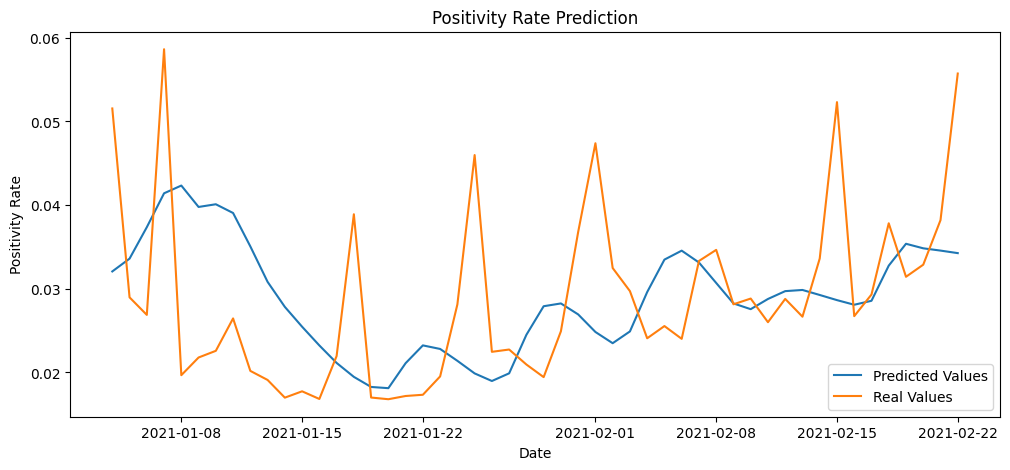

In [196]:
# Extract features and target variables
separation_date = datetime(2021,1,1)
train_dates = greece_df[greece_df['Date'] < separation_date]['Timestamp'].values.reshape(-1, 1)
train_pos_rate = greece_df[greece_df['Date'] < separation_date]['Positivity Rate'].values.reshape(-1, 1)

# Normalize the train_pos_rate
scaler = StandardScaler()
train_pos_rate_scaled = scaler.fit_transform(train_pos_rate)

# LSTM requires the data to be in a specific format, 3d tensor
train_dates_tensor = np.reshape(train_dates,(train_dates.shape[0],train_dates.shape[1],1)) 
train_pos_rate_scaled_tensor = np.reshape(train_pos_rate_scaled,(train_pos_rate_scaled.shape[0],train_pos_rate_scaled.shape[1],1))

# Build the RNN model
model = Sequential()
# model.add(LSTM(units=64, return_sequences=True, input_shape=(train_dates.shape[1], 1)))
model.add(LSTM(units=64, input_shape=(train_dates.shape[1], 1)))
# model.add(LSTM(units=64, return_sequences=True))
# model.add(LSTM(units=64))
model.add(Dense(1))

# Explanation of the parameters:
# units: The number of neurons in the LSTM layer -> 
# Since the data is not very complex and the target variable in in range 0-0.3 
# we can use a small number of neurons (64) to avoid overfitting
# Since we want to predict a single value, the output dimension is 1
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(train_dates_tensor, train_pos_rate_scaled_tensor, epochs=12, batch_size=8, verbose=0)
# Since the data size is small, we can use a small batch size

# Plot the loss
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'])
plt.title('Model Loss for Initial Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Create a list to store the predicted values
predicted_pos_rate_values = []

# Predict the remaining values ( But the last three )
remaining_dates = greece_df[greece_df['Date'] >= separation_date]['Timestamp'][:-3]
remaining_dates = remaining_dates.reset_index(drop=True)
for today in remaining_dates:
	# Online learning in the model:

	# Gather the positivity rate found today
	new_train_pos_rate = greece_df[greece_df['Timestamp'] == today]['Positivity Rate'].iloc[0]
		
	# Scale the new data
	new_train_pos_rate_scaled = scaler.transform([[new_train_pos_rate]])
	
	# LSTM requires the data to be in a specific format, 3d tensor
	today_tensor = np.reshape(today,(1,1,1)) 
	new_train_pos_rate_scaled = np.reshape(new_train_pos_rate_scaled,(1,1,1))

	# Train the model with the new data
	model.fit(today_tensor, new_train_pos_rate_scaled, epochs=8, batch_size=1, verbose=0)

	# calculate the prediction date
	predict_ts = today + 3*24*60*60
	predict_ts = np.reshape(predict_ts, (1, 1, 1))

	# Predict the positivity rate for the prediction date
	predicted_value_scaled = model.predict(predict_ts, verbose=0)
	predicted_value = scaler.inverse_transform(predicted_value_scaled.reshape(-1, 1))

	# Store the predicted value
	predicted_pos_rate_values.append(predicted_value[0][0])
	
# Calculate the MSE
predicted_pos_rate_values = predicted_pos_rate_values[:-3]
dates = greece_df[greece_df['Date'] >= separation_date]['Date'][3:-3].to_list()
real_pos_rate_values = greece_df[greece_df['Date'] >= separation_date]['Positivity Rate'][3:-3].to_list()
mse = mean_squared_error(real_pos_rate_values, predicted_pos_rate_values)
print('MSE: ', mse)
# print('Real values: ', real_pos_rate_values)
# print('Pred values: ', predicted_pos_rate_values)

# # Plot the predicted values against the real values
plt.figure(figsize=(12, 5))
plt.plot(dates, predicted_pos_rate_values, label='Predicted Values')
plt.plot(dates, real_pos_rate_values, label='Real Values')
plt.title('Positivity Rate Prediction')
plt.xlabel('Date')
plt.ylabel('Positivity Rate')
plt.legend()
plt.show()



The **RNN** is able to only **partially** capture the **spikes** in the **positivity rate**. From the grath a noticable  
**latency** can be deduced between the actual and the predicted values. The **model** is able to **follow** the **general  
trend** of the **positivity rate** but fast changes prove to be undetectable by such a simple **architecture**. The **model**  
is possibly **overfitting** the **new data** during the **online training** process due to the many **epochs** for each value.  
**In spite** of the previous speculation, the **MSE** function is **slightly deacreasing**, this could probably be attributed  
to forcing the model to weight more the **recent values** of the **positivity rate** and **ignore** faster the **past**. This  
way the model is providing **better short term** predictions with the drawback of losing generalization capabilities. We can  
also detect the effects of the spikes in the predicted values: The **model** is **overreacting** to the new data, an effect  
that is actually a common problem with **RNNs** and **LSTMs**.  
  
Possible **solutions** to the **problem** could be to **increase** the **number of features** by **shifting** the **positivity rate**  
as mentioned before, or maybe **increase** the **number of neurons** in the **LSTM layers**. Another probable solution would  
be to **interpolate data** between the real values, create more **data points** and **train** the **model** with more **epochs**.  
That could enable the model to **capture** the **instant rises and falls** in the **positivity rate**.


